### Improring the libraries

In [1]:
import COVID19Py    # Python package for easy access to the up-to-date 
                    # Coronavirus (COVID-19, SARS-CoV-2) cases data.
covid19 = COVID19Py.COVID19()

import numpy as np                        # for manipulating numerical data  
from datetime import datetime,timedelta   # for manipulating dates
import matplotlib.pyplot as plt           # for visualization
%matplotlib inline

import sklearn.metrics as sklm            # for modeling data
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

import csv   # for saving the necessary data in csv files

### Importing the data

In [2]:
country_code = "NL"
location = covid19.getLocationByCountryCode(country_code, timelines=True)   # it contains all relevant data 
                                                                            # for the Netherlands

In [3]:
location[0].keys()    # printing all the keys

dict_keys(['country_code', 'latest', 'country', 'last_updated', 'coordinates', 'timelines', 'id', 'province', 'country_population'])

In [4]:
# here we inspect what state entities exist. Usually we need to choose the empty 'province' field.
# otherwise one has to sum over all the list elements

for i in location:  
    province = i.get('province')
    if province == '':
        print('--> N/A')
    else:
        print(i.get('province'))      

Aruba
Curacao
Sint Maarten
--> N/A
Bonaire, Sint Eustatius and Saba


In [5]:
for i in location:
    province = i.get('province')
    if province == '':
        country=i.get('country')   # string (name of the country)
        
        confirmed_data=i.get('timelines').get('confirmed').get('timeline')  # unsorted list of data points (confirmed cases)        
        deaths_data=i.get('timelines').get('deaths').get('timeline')        # unsorted list of data points (deaths)
              
        dates=[i for i in sorted(confirmed_data)]                           # list of dates in the original format and
                                                

        confirmed=[confirmed_data.get(i) for i in sorted(confirmed_data)]   # sorted list of confirmed cases
        deaths=[deaths_data.get(i) for i in sorted(deaths_data)]            # sorted list of deaths  

        
confirmed_daily=np.diff(confirmed)                                  # sorted list of daily increments       
              
date_current=dates[-1][:10]    # the last element of the dates   
date_start = datetime.strptime(dates[0], '%Y-%m-%dT%H:%M:%SZ')      # datetime object (the starting point)

date_array=np.array(
      [datetime.strftime(date_start+timedelta(days=i), '%d %b %Y'     # the list of dates in str format
                              ) for i in range(len(dates)+100)]) 

In [6]:
with open('data_'+date_current+'.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(confirmed)
    wr.writerow(deaths)
    wr.writerow(dates)
    wr.writerow(date_array)
    wr.writerow(country)


In [7]:
# Importing the data from the csv file. This can be useful while assessing performance of the model later on.

# data = []
# with open('data_2020-04-06.csv') as csvfile:
#     readCSV = csv.reader(csvfile, delimiter=',')
#     for row in readCSV:
#         data.append(row)
        
# # print(data)
# confirmed=[int(i) for i in data[0]]
# deaths=[float(i) for i in data[1]]
# dates=[i for i in data[2]]
# date_array=np.array([i for i in data[3]])
# country=''.join(data[4])

# confirmed_daily=np.diff(confirmed)                                  # sorted list of daily increments 
# date_current=dates[-1][:10]    # the last element of the dates   
# date_start = datetime.strptime(dates[0], '%Y-%m-%dT%H:%M:%SZ')      # datetime object (the starting point)

### Plotting the raw data

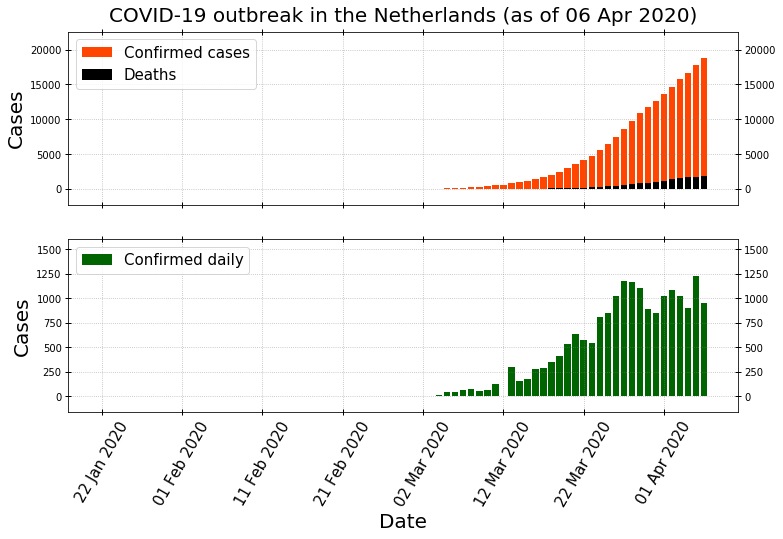

In [8]:
xArray=np.arange(len(confirmed))   # x-axis

fig, axes = plt.subplots(2, sharex=True, sharey=False)   
fig.set_size_inches(12, 7)

#########################################################################
# Visaulizing the data
#########################################################################
axes[0].bar(xArray,confirmed, color='orangered', zorder=1,  label='Confirmed cases') 

axes[0].bar(xArray,deaths, color='black',zorder=2,  label = 'Deaths')    # zorder=2 to make sure that it is plotted above

axes[0].set_ylim(-20*(np.ceil(1.2*max(confirmed)/200)),200*(np.ceil(1.2*max(confirmed)/200)))   # some way to put the y limits
axes[0].set_title('COVID-19 outbreak in the ' + country + ' (as of '+date_array[len(dates)-1]+')', fontsize=20, pad=10)

axes[1].bar(xArray[1:],confirmed_daily, color='darkgreen', label='Confirmed daily')

axes[1].set_ylim(-20*(np.ceil(1.2*max(confirmed_daily)/200)),200*(np.ceil(1.2*max(confirmed_daily)/200)))
axes[1].set_xlabel('Date', fontsize=20)

##########################################################################
# Adjusting some parameteres of the figure

for axis in axes:
    axis.tick_params(axis='x', direction='inout', length=6, width=1,
             top=True, labeltop=False)
    axis.tick_params(axis='y', which='both', direction='inout', length=6, width=1,
            top=True, labelright=True)
    axis.yaxis.set_ticks_position('both')
    axis.grid(True,which="major",ls=":",c='gray', alpha=0.6)
    axis.set_ylabel('Cases', fontsize=20)
    axis.legend(loc=2, fontsize=15)

##########################################################################
# Adjusting date labels on the x-axis

locs = axes[1].get_xticks()                         # getting the current tick locations
new_locs=[date_array[int(i)] for i in locs]         # picking the corresponding dates from date_array
axes[1].set_xticklabels([i for i in new_locs], fontsize = 15, rotation = 60)    # setting new labels

###########################################################################
# Saving the figure

plt.savefig(country+'_data_'+date_current+'.png', dpi=200, bbox_inches="tight")

### Modeling using a logistic function

In [9]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [10]:
x=np.arange(len(confirmed))   # defining x and y arrays to model
y=confirmed

print('Logistic Model -->')
fit = curve_fit(logistic_model,x,y,p0=[3,70,10000])  # choosing the initial guess

a,b,c = fit[0]
sigma_a, sigma_b, sigma_c = np.sqrt(np.diag(fit[1]))

print([ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('a','b','c'),(a,b,c))])
print([ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('sigma_a','sigma_b','sigma_c'),(sigma_a,sigma_b,sigma_c))])

y_pred = logistic_model(x,a,b,c)     # predicted values
print("R2 score: ", '{:.3f}'.format(sklm.r2_score(y,y_pred)))   # printing the coefficient of determination, or R-squared

perc_flat = 0.98                     # we define the saturation point as 98% of the max values
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - perc_flat*int(c), b))
print('Day of flattening of the infection curve')
datesol = datetime.strftime(date_start+timedelta(days=sol), '%d %b %Y' )   # printing the day when flattening occurs
print('--> '+datesol)

Logistic Model -->
['a=5.139', 'b=67.825', 'c=22996.002']
['sigma_a=0.059', 'sigma_b=0.139', 'sigma_c=255.692']
R2 score:  1.000
Day of flattening of the infection curve
--> 18 Apr 2020


In [11]:
flatasymp=sol+15   # adding 15 days after the flattening for visualization 
mean = [logistic_model(i,a,b,c) for i in np.arange(flatasymp)]     # this is a new array of data from the model
upper_lim = [logistic_model(i,a+3*sigma_a,b+3*sigma_b,c+3*sigma_c) for i in np.arange(flatasymp)]   # upper 3-sigma boundary
lower_lim = [logistic_model(i,a-3*sigma_a,b-3*sigma_b,c-3*sigma_c) for i in np.arange(flatasymp)]   # lower 3-sigma boundary

In [12]:
print(int(mean[-1]),int(upper_lim[-1]),int(lower_lim[-1]),int(upper_lim[-1])-int(mean[-1]),int(mean[-1])-int(lower_lim[-1]))

22959 23713 22203 754 756


In [13]:
error = int((upper_lim[-1]-lower_lim[-1])/2)   # error bar at the end of modeling
mean_final=int(mean[-1])                       # final values at the end of modeling  

print('Predicted total number of confirmed cases: ' + str(mean_final)+' \xb1 '+ str(error))

Predicted total number of confirmed cases: 22959 ± 754


### Visualising the original data and the model

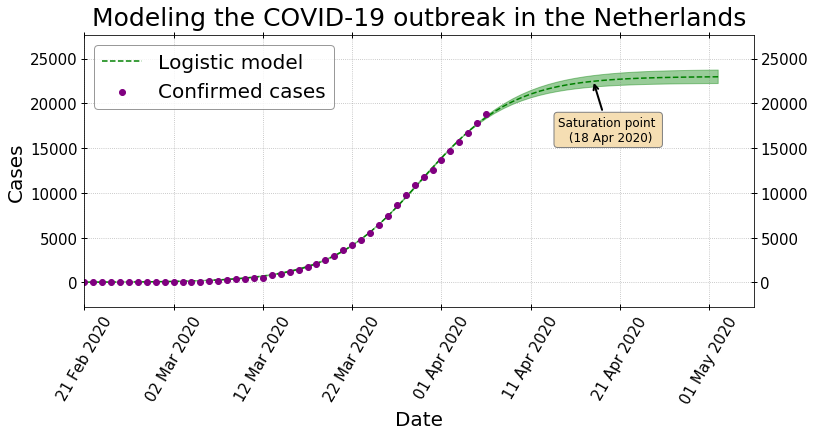

In [14]:
xArr_model=np.arange(len(mean))

fig, ax = plt.subplots(1)   
fig.set_size_inches(12, 5)

#########################################################################
# Visaulizing the data
#########################################################################

ax.scatter(xArray,confirmed, color='purple', zorder=2,  label='Confirmed cases') 

ax.annotate('Saturation point \n ('+datesol+')', xy=(sol, np.max(mean)*0.98),  xycoords='data',
            fontsize=12, bbox=dict(boxstyle='round', fc='wheat', ec='gray'),
            xytext=(15, -60), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", linewidth=2))

ax.plot(xArr_model, mean, 'g--', zorder=1, label = 'Logistic model')

ax.fill_between(xArr_model, upper_lim, lower_lim, color='green', alpha=0.4, zorder=1)

##########################################################################
# Adjusting some parameteres of the figure

ax.tick_params(axis='x', direction='inout', length=6, width=1,
         top=True, labeltop=False, labelsize=15)
ax.tick_params(axis='y', which='both', direction='inout', length=6, width=1,
        top=True, labelright=True, labelsize=15)
ax.yaxis.set_ticks_position('both')
ax.grid(True,which="major",ls=":",c='gray', alpha=0.6)

ax.set_ylim(-20*(np.ceil(1.2*max(mean)/200)),200*(np.ceil(1.2*max(mean)/200)))

ax.legend(loc=2, fontsize=20, edgecolor='gray')

ax.set_ylabel('Cases', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_title('Modeling the COVID-19 outbreak in the ' + country, fontsize=25, pad=10)

##########################################################################
# Adjusting date labels on the x-axis

ax.set_xlim(30,105)
locs = ax.get_xticks()
new_locs=[date_array[int(i)] for i in locs]
ax.set_xticklabels([i for i in new_locs], fontsize = 15, rotation = 60) 

###########################################################################
# Saving the figure

plt.savefig(country+'_model_'+date_current+'.png', dpi=200, bbox_inches="tight")

In [15]:
mean_diff=np.diff(mean)                # daily cases from the model

upper_lim_diff = np.diff(upper_lim)    # 3-sigma boundaries
lower_lim_diff = np.diff(lower_lim)

In [16]:
max_index=np.argmax(mean_diff)         # index when the maximum of daily cases occur
date_max=date_array[max_index]         # and the corresponding date
print('The peak of the outbreak: '+date_max)

The peak of the outbreak: 29 Mar 2020


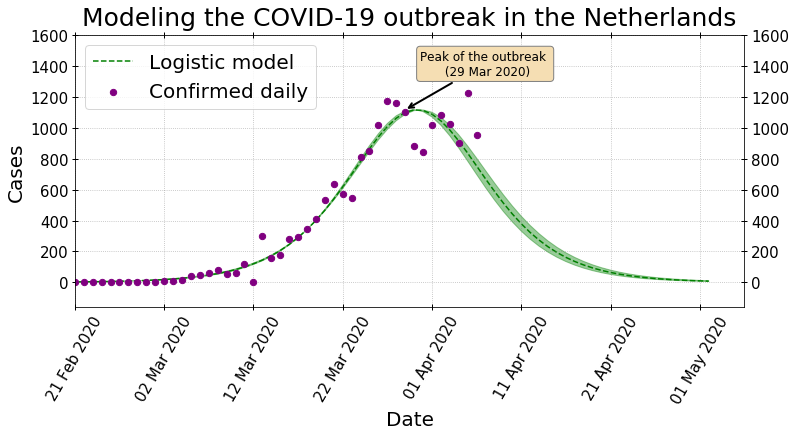

In [17]:
fig, ax = plt.subplots(1)   
fig.set_size_inches(12, 5)

#########################################################################
# Visaulizing the data
#########################################################################

ax.scatter(xArray[1:],confirmed_daily, s=40, color='purple', zorder=2,  label='Confirmed daily')

ax.annotate('Peak of the outbreak \n ('+date_max+')', xy=(max_index, max(mean_diff)),  xycoords='data',
            fontsize=12, bbox=dict(boxstyle='round', fc='wheat', ec='gray'),
            xytext=(80, 35), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", linewidth=2))

ax.plot(xArr_model[1:], mean_diff, 'g--', zorder=1, label = 'Logistic model')
ax.fill_between(xArr_model[1:], upper_lim_diff, lower_lim_diff, color='g', alpha=0.4)

##########################################################################
# Adjusting some parameteres of the figure

ax.tick_params(axis='x', direction='inout', length=6, width=1,
         top=True, labeltop=False, labelsize=15)
ax.tick_params(axis='y', which='both', direction='inout', length=6, width=1,
        top=True, labelright=True, labelsize=15)
ax.yaxis.set_ticks_position('both')
ax.grid(True,which="major",ls=":",c='gray', alpha=0.6)

ax.set_ylim(-20*(np.ceil(1.4*max(mean_diff)/200)),200*(np.ceil(1.4*max(mean_diff)/200)))

ax.legend(loc=2, fontsize=20)

ax.set_ylabel('Cases', fontsize=20)
ax.set_xlabel('Date', fontsize=20)

ax.set_title('Modeling the COVID-19 outbreak in the ' + country, fontsize=25, pad=10)

##########################################################################
# Adjusting date labels on the x-axis

ax.set_xlim(30,105)
locs = ax.get_xticks()
new_locs=[date_array[int(i)] for i in locs]
ax.set_xticklabels([i for i in new_locs], fontsize = 15, rotation = 60) 

###########################################################################
# Saving the figure

plt.savefig(country+'_model_daily_'+date_current+'.png', dpi=200, bbox_inches="tight")